# Principal Portfolio Replication

This code tries to replicate the empirical results from the Principal Portfolio paper. It uses the code from the Python file 'PrinPort'.

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem

import PrinPort as pp

### Structure

1. Replicating the Fama-French Empirical results
    - Data and Preparation
    - Creating Period Returns
    - Creating Momentum signal
    - Principal Portfolios
    - Principal Exposure Portfolios
    - Principal Alpha Portfolios
    - Figure 1 replication
    - 
2. Replicating the Factor Timing empirical results

### 1. Fama-French Empirical Results

##### Data and Preparation

In [2]:
# Read in 25 FF portfolios based on size and book-to-market (Average value weighted return - daily)
ff_df = pd.read_csv('25_Portfolios_5x5_Daily.csv')


# Create date variable
year = []
month = []
day = []
for i in range(0, len(ff_df)):
    year.append(str(ff_df.iloc[:, 0][i])[:4])
    month.append(str(ff_df.iloc[:, 0][i])[4:6])
    day.append(str(ff_df.iloc[:, 0][i])[6:])

ff_df['year'] = year
ff_df['month'] = month
ff_df['day'] = day
ff_df['date'] = pd.to_datetime(dict(year=ff_df.year, month=ff_df.month, day=ff_df.day))

ff_df = ff_df.drop(['year', 'month', 'day', 'Unnamed: 0'], axis=1)

# Uses data from July 1963 to end of 2019
ff_df = ff_df[ (ff_df['date'] >= '1953-10-01') & (ff_df['date'] <= '2019-12-31')]
ff_df = ff_df.drop(['date'], axis=1) # Drops the date variable again

# Visualize the dataframe
ff_df

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
7968,1.38,0.83,-0.19,-0.17,0.17,0.73,0.32,0.27,0.26,0.51,...,0.48,0.60,0.72,0.63,0.49,0.83,0.55,0.50,0.24,0.40
7969,0.61,0.05,0.93,0.57,0.21,0.20,0.07,0.51,-0.01,-0.25,...,0.15,0.35,0.17,0.29,0.05,0.59,0.36,0.43,-0.08,-0.08
7970,-2.88,0.06,-0.30,-0.57,-0.43,-0.12,-0.59,-0.13,-0.19,-0.91,...,-0.53,0.05,-0.19,-0.44,-0.89,-0.49,-0.33,-0.39,-0.04,-1.06
7971,-0.74,-1.04,-0.45,-0.40,-0.68,-1.02,-0.68,-0.94,-0.84,-0.47,...,-0.80,-0.61,-0.57,-0.40,-0.48,-0.44,-0.43,-0.62,-0.57,-0.61
7972,1.32,1.47,0.94,0.37,0.52,0.17,1.01,0.55,-0.19,0.79,...,0.58,0.30,1.02,0.88,1.20,0.89,0.62,0.57,0.57,1.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24638,1.05,1.41,0.65,0.54,0.60,0.58,0.42,0.40,0.24,0.44,...,0.08,0.07,0.07,-0.01,-0.09,-0.02,-0.06,0.12,0.02,0.11
24639,0.44,-0.03,-0.03,0.14,0.32,-0.23,-0.80,-0.34,-0.12,0.20,...,0.23,0.20,0.19,0.03,0.49,0.76,0.43,0.40,0.36,0.69
24640,-1.54,-1.25,-0.82,-0.51,-0.90,-0.84,-0.71,-0.31,-0.48,-1.11,...,-0.18,-0.20,-0.12,-0.35,-0.57,0.07,-0.06,-0.05,-0.16,-0.34
24641,-0.93,0.07,-0.10,0.03,-0.11,-0.80,-0.44,-0.11,0.08,0.10,...,-0.71,-0.29,-0.24,-0.16,-0.14,-0.64,-0.80,-0.12,-0.41,-0.37


In [3]:
# Create 20-days cumulative returns with 1 day in between every period
df_log = np.log(ff_df/100 +  1) # Calculate log returns

periods = round( len(df_log) / 21 ) # Maximum number of periods in the data. Keep in mind we always have to round down

assets_count = df_log.shape[1] # Number of assets in the data

# This loop creates the 20 days cumulative returns based on the log returns
###################################################################################

assets_name = [] # List holder for the asset names
assets_return = [] # List holder for assets returns over all periods
for a in range(0, assets_count): # Loops across the assets (columns in df_log)
    assets_name.append( df_log.columns[a] ) # Append the name of the current asset

    period_return = [] # List holder for the period returns

    for p in range(0, periods): # Looops over the periods
        begin = p * 21 # At what index the current period begins

        period_return.append( df_log.iloc[:, a][begin : begin + 20].sum() ) # Calculate the cumulative return of the current period
    
    assets_return.append(period_return)


# Sets everything together into a new dataframe
df_periods = pd.DataFrame(np.asarray(assets_return).T, columns= assets_name)
df_periods



,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
0,0.001189,0.027372,0.034192,0.011978,0.026625,0.003614,0.032478,0.035814,0.028959,0.030175,...,0.044681,0.043504,0.050821,0.039257,0.028863,0.052582,0.037721,0.046951,0.060315,0.037493
1,-0.016026,0.038037,0.019309,0.015185,0.025856,0.027842,0.030848,0.030195,0.009934,0.017516,...,0.032867,0.039184,0.040677,0.044697,0.039973,0.045696,0.028591,0.034439,0.036844,0.027900
2,0.014017,0.003261,0.006826,-0.002216,-0.024261,-0.020756,0.011867,-0.001615,-0.009847,-0.014669,...,0.005517,-0.002869,-0.001229,-0.004128,-0.018839,-0.000909,0.005270,-0.003688,-0.001619,-0.027049
3,0.043264,0.026935,0.004457,0.036241,0.046161,0.022827,0.033201,0.032120,0.028276,0.043417,...,0.028655,0.033538,0.042722,0.022315,0.043334,0.022157,0.038363,0.053383,0.052717,0.032263
4,-0.023936,0.021054,0.010285,0.013220,0.009304,0.018382,0.004178,0.029071,0.031574,-0.005617,...,0.029713,0.020190,0.038446,0.034134,0.004557,0.023601,0.032321,0.027899,-0.001873,0.035276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,-0.056960,-0.069421,-0.090191,-0.078462,-0.107380,-0.026605,-0.084529,-0.068524,-0.077569,-0.120089,...,-0.031039,-0.064353,-0.070479,-0.071637,-0.109509,-0.013209,-0.038437,-0.046655,-0.051142,-0.112163
790,-0.031609,-0.003266,0.025568,0.050877,0.071493,-0.021420,0.014782,0.039153,0.055287,0.031803,...,-0.043241,0.028421,0.050460,0.060361,0.060779,-0.005012,0.011624,0.029537,0.049837,0.059670
791,0.013770,0.011600,0.010792,0.015755,0.017191,0.042329,0.046630,0.030341,0.034495,0.031010,...,0.032079,0.021676,0.002792,0.008166,-0.007223,0.028518,0.020199,0.022243,0.022076,0.051781
792,0.056540,0.035629,0.022268,0.024753,0.014115,0.063054,0.028443,0.019354,0.026829,-0.007612,...,0.072713,0.035044,0.028473,0.021324,0.001472,0.040710,0.046504,0.024900,0.021926,0.033662


##### Creating Period Returns

In [4]:
# Creating the returns. The returns are cross-sectional demeaned
df_returns = df_periods.sub(df_periods.mean(axis=1), axis=0)

# We shift the returns one period ahead since we want to predict the returns in the future from the current signal
# I.e. we want to predict returns in period t+1 from the signal in period t
df_returns = df_returns.shift(+1)
df_returns = df_returns.iloc[1: , :] # Drops the first row since we do not have returns for that (because of the shifting). Keep in mind index now starting at 1
df_returns


,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
1,-0.034084,-0.007901,-0.001080,-0.023295,-0.008648,-0.031659,-0.002795,0.000541,-0.006314,-0.005098,...,0.009408,0.008231,0.015548,0.003984,-0.006410,0.017309,0.002448,0.011678,0.025042,0.002220
2,-0.043863,0.010201,-0.008528,-0.012652,-0.001981,0.000006,0.003011,0.002359,-0.017903,-0.010320,...,0.005030,0.011348,0.012841,0.016860,0.012136,0.017859,0.000754,0.006602,0.009007,0.000063
3,0.018559,0.007803,0.011368,0.002326,-0.019719,-0.016214,0.016409,0.002927,-0.005305,-0.010127,...,0.010059,0.001673,0.003313,0.000414,-0.014297,0.003633,0.009812,0.000854,0.002923,-0.022507
4,0.007980,-0.008349,-0.030827,0.000957,0.010876,-0.012457,-0.002083,-0.003164,-0.007009,0.008133,...,-0.006629,-0.001747,0.007437,-0.012970,0.008050,-0.013127,0.003079,0.018099,0.017433,-0.003021
5,-0.042581,0.002408,-0.008360,-0.005426,-0.009342,-0.000264,-0.014468,0.010425,0.012928,-0.024262,...,0.011067,0.001544,0.019800,0.015488,-0.014088,0.004955,0.013675,0.009253,-0.020519,0.016630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,-0.033765,-0.006612,-0.021215,-0.018825,-0.029742,-0.020954,0.003763,-0.002077,0.004384,-0.008770,...,0.014561,0.010519,0.009729,-0.009600,-0.002937,0.010643,0.014612,0.015091,-0.002471,0.019819
790,0.016001,0.003540,-0.017229,-0.005501,-0.034418,0.046356,-0.011568,0.004437,-0.004608,-0.047128,...,0.041923,0.008608,0.002482,0.001325,-0.036548,0.059752,0.034524,0.026307,0.021819,-0.039202
791,-0.057545,-0.029202,-0.000367,0.024942,0.045558,-0.047355,-0.011154,0.013218,0.029352,0.005868,...,-0.069176,0.002486,0.024524,0.034426,0.034844,-0.030947,-0.014311,0.003602,0.023902,0.033735
792,-0.010772,-0.012942,-0.013750,-0.008787,-0.007351,0.017787,0.022088,0.005800,0.009953,0.006468,...,0.007538,-0.002865,-0.021750,-0.016376,-0.031765,0.003976,-0.004343,-0.002299,-0.002465,0.027239


##### Creating Momentum Signal

In [5]:
# Create the signal, which is a rescaling of the returns. The rescaling is done by
# 1) Ranking the assets within a single period, and using that ranking number
# 2) Then dividing the ranking numbers with the total amount of assets
# 3) And subtracting the mean of that number
#
# This creates a cross-sectional map of the signal in each period, with the signals being in [-0.5 : 0.5]

signal_rows = []
for  i in range(0 , len(df_periods)):
    signal_rows.append(df_periods.iloc[i,:].rank() / assets_count - (df_periods.iloc[i,:].rank() / assets_count).mean())

df_signal = pd.DataFrame(signal_rows, columns= assets_name)

# Drops the frist row, since we do not have returns for that (because of the shifting). Keep in mind index now starting at 1
df_signal = df_signal.iloc[1:, :]
df_signal


,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
1,-0.48,0.28,-0.28,-0.40,-0.16,-0.08,0.08,0.04,-0.44,-0.36,...,0.12,0.32,0.40,0.44,0.36,0.48,0.000000e+00,1.600000e-01,2.400000e-01,-0.04
2,0.48,0.28,0.40,0.04,-0.44,-0.40,0.44,0.12,-0.20,-0.32,...,0.36,-0.04,0.16,-0.16,-0.36,0.20,3.200000e-01,-1.200000e-01,8.000000e-02,-0.48
3,0.24,-0.32,-0.48,0.04,0.40,-0.36,-0.08,-0.20,-0.28,0.32,...,-0.24,-0.04,0.20,-0.40,0.28,-0.44,8.000000e-02,4.800000e-01,4.400000e-01,-0.16
4,-0.48,-0.04,-0.20,-0.16,-0.24,-0.12,-0.36,0.20,0.28,-0.44,...,0.24,-0.08,0.48,0.40,-0.32,0.04,3.600000e-01,1.200000e-01,-4.000000e-01,0.44
5,0.44,0.48,0.04,0.08,-0.20,0.12,-0.24,0.32,-0.04,-0.16,...,0.24,-0.12,0.16,-0.28,-0.40,0.40,1.110223e-16,-3.200000e-01,2.800000e-01,-0.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,0.24,0.08,-0.24,-0.16,-0.32,0.44,-0.20,0.12,-0.12,-0.44,...,0.40,0.16,0.04,0.00,-0.36,0.48,3.600000e-01,3.200000e-01,2.800000e-01,-0.40
790,-0.40,-0.28,-0.12,0.20,0.48,-0.36,-0.16,0.08,0.24,0.04,...,-0.48,-0.04,0.16,0.36,0.40,-0.32,-2.000000e-01,0.000000e+00,1.200000e-01,0.32
791,-0.28,-0.32,-0.36,-0.24,-0.20,0.36,0.44,0.16,0.28,0.20,...,0.24,-0.12,-0.44,-0.40,-0.48,0.12,-1.600000e-01,1.110223e-16,-4.000000e-02,0.48
792,0.36,0.24,-0.16,-0.12,-0.36,0.44,0.00,-0.28,-0.04,-0.48,...,0.48,0.16,0.04,-0.24,-0.44,0.28,3.200000e-01,-8.000000e-02,-2.000000e-01,0.12


##### Principal Portfolios

In [6]:
# Creating the PPs over the data to replicate results
# Lets loop over windows of 120 periods and collect the singular values

S_collect = []
return_collect = []
for p in range(0, len(df_returns)-122):
    L, S, L_k = pp.principal_portfolio(np.asarray(df_returns.iloc[p: p + 120, :]), np.asarray(df_signal.iloc[p: p + 120, :]))
    S_collect.append(S)

    # We can calculate returns from the last period since data is out of bound ( we do not have that data)
    if p == p:
        # print(p, p+120)
        # print(p + 121)

        period_return_collect = []
        # Calculate returns in each period
        for s in range(0, len(S)):
            #L = np.outer(V[:, s], U[:, s])
            single_signal = np.asarray(df_signal.iloc[p + 122, :]).reshape(len(S), -1).T
            return1 = np.asarray(df_returns.iloc[p + 122,:]).reshape(len(S), -1)
            w = single_signal @ L_k[s]
            
            return_ = w @ return1

            period_return_collect.append(return_[0][0])

        return_collect.append(period_return_collect)
        

S_collect = np.asarray(S_collect)
return_collect = np.asarray(return_collect)

In [7]:
# Calculate the mean of the singular values to replicate Figure 1 Panel A
S_mean = []
for i in range(0, 25):
    S_mean.append(S_collect[:, i ].mean() * 100)
S_mean = np.asarray(S_mean)
S_mean

array([1.63035788e+00, 8.22467431e-01, 4.95789225e-01, 3.36191055e-01,
       2.72321237e-01, 2.29902929e-01, 1.94176138e-01, 1.69405757e-01,
       1.46908445e-01, 1.28238839e-01, 1.13658202e-01, 9.96020351e-02,
       8.75193999e-02, 7.75505713e-02, 6.83948736e-02, 5.94379270e-02,
       5.09528112e-02, 4.33182538e-02, 3.56184538e-02, 2.86811722e-02,
       2.19676631e-02, 1.50128179e-02, 8.68902958e-03, 2.97636708e-03,
       2.62785645e-17])

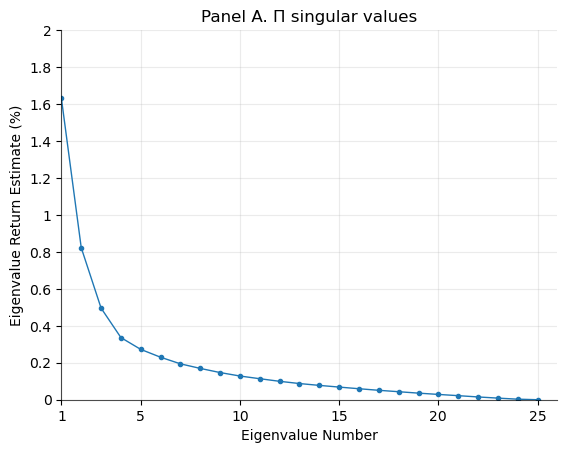

In [8]:
# This plot replicates the Figure 1 Panel A
fig, ax = plt.subplots()
ax.plot(S_mean, linewidth= 1, marker= '.')
ax.grid(1, alpha= 0.25)

ax.set_yticks( np.arange(0, 2.0001, step= 0.2), [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2])
ax.set_xticks([0, 4, 9, 14, 19, 24], [1, 5, 10, 15, 20, 25])
ax.set_ylim(0, 2)
ax.set_xlim(0, 25)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.7)
ax.spines['left'].set_alpha(0.7)

ax.set_title('Panel A. Π singular values')
ax.set_ylabel('Eigenvalue Return Estimate (%)')
ax.set_xlabel('Eigenvalue Number')

plt.savefig('./Replication Figures/Figure 1 - Panel A (Replication)')

In [9]:
# Calculate the mean of the returns to replicate Figure 1 Panel D
R_mean = []
ste = [] # standard error of mean
for i in range(0, 25):
    R_mean.append(return_collect[:, i ].mean() * 100)
    ste.append(sem(return_collect[:, i ] *100))
PP_ste = np.asarray(ste)
PP_mean = np.asarray(R_mean)
PP_mean

array([ 8.89706658e-01,  3.59112459e-01,  1.42727155e-01,  7.10881340e-03,
        1.83115147e-02,  3.62322379e-02,  3.55860978e-03,  1.87939454e-02,
        3.69384367e-02, -6.63158055e-03, -1.68389059e-03,  1.13280971e-02,
       -1.34977221e-02,  6.01348866e-03,  8.35814221e-03, -2.01369900e-02,
       -2.32121295e-03, -1.42032921e-02, -2.07918510e-02,  8.67999955e-04,
        2.18888247e-02, -1.14311635e-02, -4.17762038e-03,  2.42987284e-03,
        6.03346647e-18])

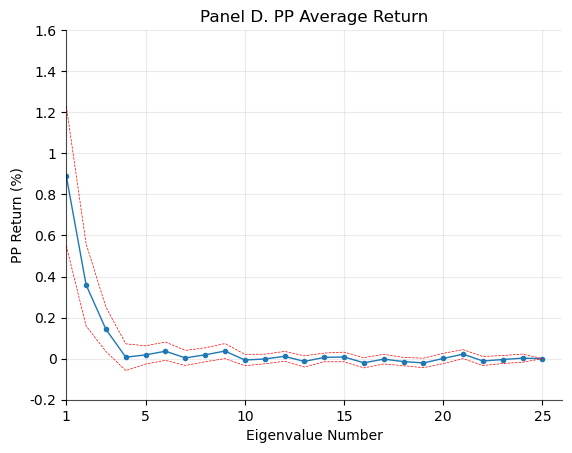

In [10]:
# This plot replicates the Figure 1 Panel A
fig, ax = plt.subplots()
ax.plot(PP_mean, linewidth= 1, marker= '.')
ax.plot((PP_mean + 2*PP_ste), linewidth= 0.5, linestyle= '--', alpha= 1, color= 'r')
ax.plot((PP_mean - 2*PP_ste), linewidth= 0.5, linestyle= '--', alpha= 1, color= 'r')
ax.grid(1, alpha= 0.25)

ax.set_yticks( np.arange(-0.2, 1.8, step= 0.2), [-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6])
ax.set_xticks([0, 4, 9, 14, 19, 24], [1, 5, 10, 15, 20, 25])
ax.set_ylim(-0.2, 1.6)
ax.set_xlim(0, 25)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.7)
ax.spines['left'].set_alpha(0.7)

ax.set_title('Panel D. PP Average Return')
ax.set_ylabel('PP Return (%)')
ax.set_xlabel('Eigenvalue Number')

plt.savefig('./Replication Figures/Figure 1 - Panel D (Replication)')

##### Principal Exposure Portfolios

In [9]:
# Creating the PPs over the data to replicate results
# Lets loop over windows of 120 periods and collect the singular values

S_collect = []
return_collect = []
for p in range(0, len(df_returns)-122):
    if p < len(df_returns) - 10:
        L, S, L_k = pp.principal_exposure_portfolio(np.asarray(df_returns.iloc[p: p + 120, :]), np.asarray(df_signal.iloc[p: p + 120, :]))
        S_collect.append(S)

    # We can calculate returns from the last period since data is out of bound ( we do not have that data)
    if p < len(df_returns) - 122:
        # print(p, p+120)
        # print(p + 121)

        period_return_collect = []
        # Calculate returns in each period
        for s in range(0, len(S)):
            #L = np.outer(V[:, s], U[:, s])
            single_signal = np.asarray(df_signal.iloc[p + 122, :]).reshape(len(S), -1).T
            return1 = np.asarray(df_returns.iloc[p + 122,:]).reshape(len(S), -1)
            w = single_signal @ L_k[s]
        
            return_ = w @ return1

            period_return_collect.append(return_[0][0])

        return_collect.append(period_return_collect)
        

S_collect = np.asarray(S_collect)
return_collect = np.asarray(return_collect)

In [12]:
# Calculate the mean of the singular values to replicate Figure 1 Panel A
Es_mean = []
for i in range(0, 25):
    Es_mean.append(S_collect[:, i ].mean() * 100)
Es_mean = np.asarray(Es_mean)
Es_mean = np.sort(Es_mean)[::-1] 
Es_mean

array([ 1.34429913e+00,  5.84062564e-01,  2.33187311e-01,  1.61966603e-01,
        1.15911765e-01,  8.56864082e-02,  6.72997542e-02,  5.15230565e-02,
        3.79794393e-02,  2.54901513e-02,  1.37641304e-02,  5.49512913e-03,
        7.46679163e-05, -4.22683320e-03, -1.21713340e-02, -2.07744683e-02,
       -3.16305302e-02, -4.31214304e-02, -5.60885864e-02, -7.24185809e-02,
       -9.25023757e-02, -1.15808664e-01, -1.56575900e-01, -2.23274290e-01,
       -3.38918282e-01])

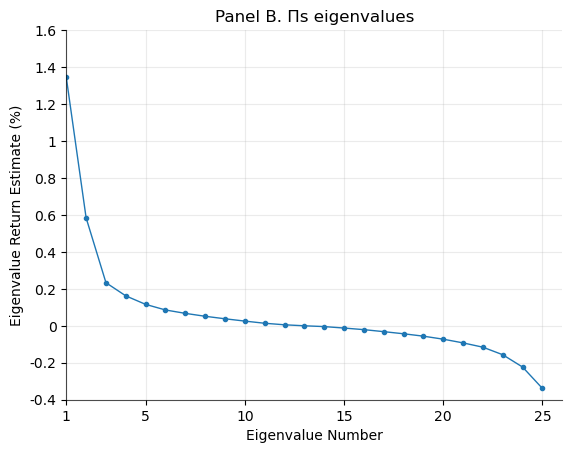

In [13]:
# This plot replicates the Figure 1 Panel B
fig, ax = plt.subplots()
ax.plot(Es_mean, linewidth= 1, marker= '.')
ax.grid(1, alpha= 0.25)

ax.set_yticks( np.arange(-0.4, 1.600001, step= 0.2), [-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6])
ax.set_xticks([0, 4, 9, 14, 19, 24], [1, 5, 10, 15, 20, 25])
ax.set_ylim(-0.4, 1.6)
ax.set_xlim(0, 25)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.7)
ax.spines['left'].set_alpha(0.7)

ax.set_title('Panel B. Πs eigenvalues')
ax.set_ylabel('Eigenvalue Return Estimate (%)')
ax.set_xlabel('Eigenvalue Number')

plt.savefig('./Replication Figures/Figure 1 - Panel B (Replication)')

In [14]:
# Calculate the mean of the returns to replicate Figure 1 Panel D
R_mean = []
ste = [] # standard error of mean
for i in range(0, 25):
    R_mean.append(return_collect[:, i ].mean() * 100)
    ste.append(sem(return_collect[:, i ] *100))
PEP_ste = np.asarray(ste)
PEP_mean = np.asarray(R_mean)
PEP_mean

array([ 8.17810766e-01,  3.63075497e-01, -2.04122017e-02,  4.46517588e-02,
        2.22711305e-02,  1.78131002e-03,  1.21851145e-02,  2.67299343e-03,
        7.08106559e-03,  3.97950530e-03,  1.13097498e-02, -1.43245647e-03,
        5.52575449e-03,  9.37695135e-04,  8.19129382e-03, -2.40154905e-04,
        2.19933486e-02,  2.03168201e-02,  2.12591294e-02,  1.49390884e-02,
        1.86318283e-02,  1.35399696e-02,  1.41624126e-03, -4.28157499e-03,
        6.92727716e-02])

Text(0.5, 0, 'Eigenvalue Number')

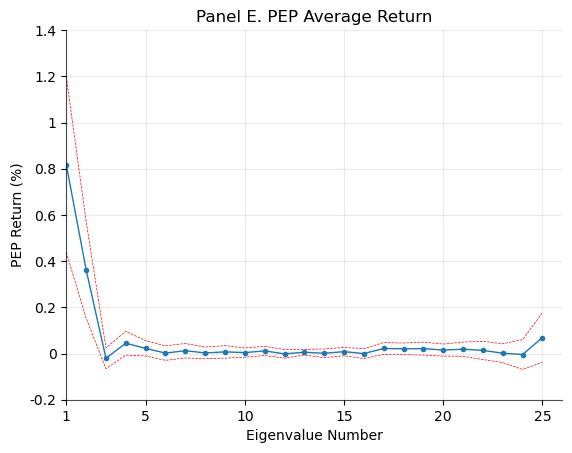

In [20]:
# This plot replicates the Figure 1 Panel A
fig, ax = plt.subplots()
ax.plot(PEP_mean, linewidth= 1, marker= '.')
ax.plot((PEP_mean + 2*PEP_ste), linewidth= 0.5, linestyle= '--', alpha= 1, color= 'r')
ax.plot((PEP_mean - 2*PEP_ste), linewidth= 0.5, linestyle= '--', alpha= 1, color= 'r')
ax.grid(1, alpha= 0.25)

ax.set_yticks( np.arange(-0.2, 1.400001, step= 0.2), [-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4])
ax.set_xticks([0, 4, 9, 14, 19, 24], [1, 5, 10, 15, 20, 25])
ax.set_ylim(-0.2, 1.4)
ax.set_xlim(0, 25)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.7)
ax.spines['left'].set_alpha(0.7)

ax.set_title('Panel E. PEP Average Return')
ax.set_ylabel('PEP Return (%)')
ax.set_xlabel('Eigenvalue Number')

#plt.savefig('./Replication Figures/Figure 1 - Panel E (Replication)')

##### Principal Alpha Portfolios

In [6]:
# Creating the PPs over the data to replicate results
# Lets loop over windows of 120 periods and collect the singular values

S_collect = []
return_collect = []
for p in range(0, len(df_returns)-122):
    if p < len(df_returns) - 10:
        L, S, L_k = pp.principal_alpha_portfolio(np.asarray(df_returns.iloc[p: p + 120, :]), np.asarray(df_signal.iloc[p: p + 120, :]), eff=True)
        S_imag = np.imag(S[:12])
        S_collect.append(S_imag)


    # We can calculate returns from the last period since data is out of bound ( we do not have that data)
    if p < len(df_returns) - 122:
        # print(p, p+120)
        # print(p + 121)

        period_return_collect = []
        # Calculate returns in each period
        for s in range(0, int(len(S)/2)):
            #L = np.outer(V[:, s], U[:, s])
            single_signal = np.asarray(df_signal.iloc[p + 122, :]).reshape(len(S), -1).T
            return1 = np.asarray(df_returns.iloc[p + 122,:]).reshape(len(S), -1)
            w = single_signal @ L_k[s]
            
            return_ = w @ return1

            period_return_collect.append(return_[0][0])

        return_collect.append(period_return_collect)
        

S_collect = np.asarray(S_collect)
return_collect = np.asarray(return_collect)

In [17]:
# Calculate the mean of the singular values to replicate Figure 1 Panel A
Ea_mean = []
for i in range(0, 12):
    Ea_mean.append(S_collect[:, i ].mean() * 100)
Ea_mean = np.asarray(Ea_mean)
Ea_mean = np.sort(Ea_mean)[::-1] 
Ea_mean

array([0.78625966, 0.31107203, 0.17989596, 0.13580235, 0.1021772 ,
       0.07799702, 0.06217294, 0.04783528, 0.03466814, 0.02294836,
       0.01214718, 0.00298321])

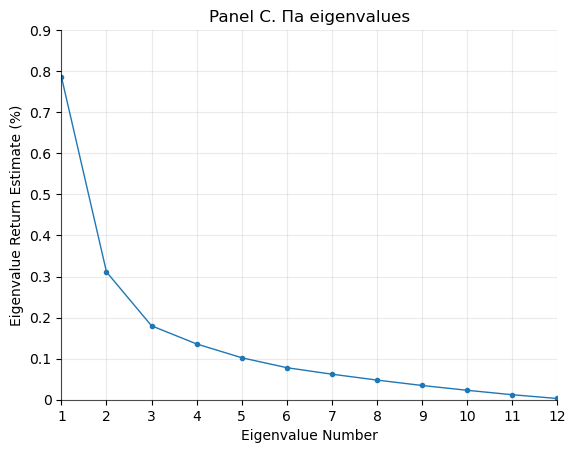

In [18]:
# This plot replicates the Figure 1 Panel B
fig, ax = plt.subplots()
ax.plot(Ea_mean, linewidth= 1, marker= '.')
ax.grid(1, alpha= 0.25)

ax.set_yticks( np.arange(0, 0.900000001, step= 0.1), [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_ylim(0, 0.9)
ax.set_xlim(0, 11)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.7)
ax.spines['left'].set_alpha(0.7)

ax.set_title('Panel C. Πa eigenvalues')
ax.set_ylabel('Eigenvalue Return Estimate (%)')
ax.set_xlabel('Eigenvalue Number')

plt.savefig('./Replication Figures/Figure 1 - Panel C (Replication)')

In [19]:
# Calculate the mean of the returns to replicate Figure 1 Panel D
R_mean = []
ste = [] # standard error of mean
for i in range(0, 12):
    R_mean.append(return_collect[:, i ].mean() * 100)
    ste.append(sem(return_collect[:, i ] *100))
PAP_ste = np.asarray(ste)
PAP_mean = np.asarray(R_mean)
PAP_mean

array([-0.31580922, -0.05805497,  0.00146177, -0.01504661, -0.01716927,
        0.00981269, -0.00919666,  0.0059957 , -0.01643736,  0.0044306 ,
        0.01550747,  0.01745077])

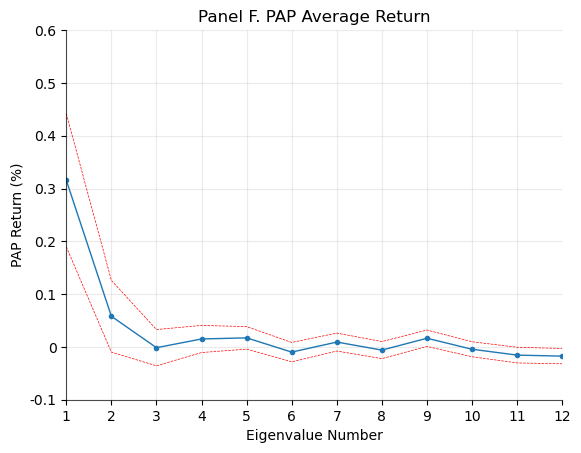

In [17]:
# This plot replicates the Figure 1 Panel A
fig, ax = plt.subplots()
ax.plot(-PAP_mean, linewidth= 1, marker= '.')
ax.plot((-PAP_mean + 2*PAP_ste), linewidth= 0.5, linestyle= '--', alpha= 1, color= 'r')
ax.plot((-PAP_mean - 2*PAP_ste), linewidth= 0.5, linestyle= '--', alpha= 1, color= 'r')
ax.grid(1, alpha= 0.25)

ax.set_yticks( np.arange(-0.1, 0.600000001, step= 0.1), [-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_ylim(-0.1, 0.6)
ax.set_xlim(0, 11)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.7)
ax.spines['left'].set_alpha(0.7)

ax.set_title('Panel F. PAP Average Return')
ax.set_ylabel('PAP Return (%)')
ax.set_xlabel('Eigenvalue Number')

plt.savefig('./Replication Figures/Figure 1 - Panel F (Replication 1)')

##### Figure 1

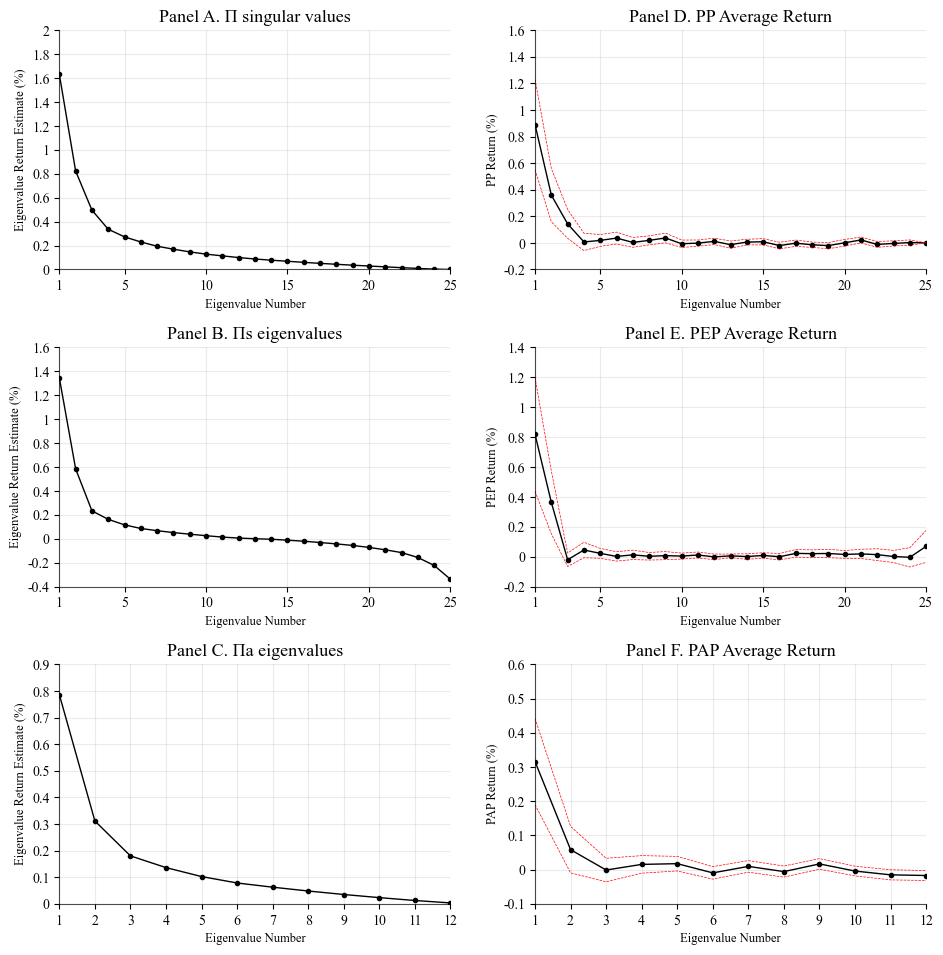

In [18]:
# Code for Figure 1

# Change font globally
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(3, 2, figsize= (10, 10))
fig.tight_layout(pad=3.5)

# PANEL A
ax[0,0].plot(S_mean, linewidth= 1, marker= '.', color = 'black')
ax[0,0].grid(1, alpha= 0.25)

ax[0,0].set_yticks( np.arange(0, 2.0001, step= 0.2), [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2])
ax[0,0].set_xticks([0, 4, 9, 14, 19, 24], [1, 5, 10, 15, 20, 25])
ax[0,0].set_ylim(0, 2)
ax[0,0].set_xlim(0, 24)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['bottom'].set_alpha(0.7)
ax[0,0].spines['left'].set_alpha(0.7)

ax[0,0].set_title('Panel A. Π singular values', size = 13)
ax[0,0].set_ylabel('Eigenvalue Return Estimate (%)', size= 9)
ax[0,0].set_xlabel('Eigenvalue Number', size= 9)

# PANEL D
ax[0,1].plot(PP_mean, linewidth= 1, marker= '.', color = 'black')
ax[0,1].plot((PP_mean + 2*PP_ste), linewidth= 0.5, linestyle= '--', alpha= 1, color= 'r')
ax[0,1].plot((PP_mean - 2*PP_ste), linewidth= 0.5, linestyle= '--', alpha= 1, color= 'r')
ax[0,1].grid(1, alpha= 0.25)

ax[0,1].set_yticks( np.arange(-0.2, 1.8, step= 0.2), [-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6])
ax[0,1].set_xticks([0, 4, 9, 14, 19, 24], [1, 5, 10, 15, 20, 25])
ax[0,1].set_ylim(-0.2, 1.6)
ax[0,1].set_xlim(0, 24)

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['bottom'].set_alpha(0.7)
ax[0,1].spines['left'].set_alpha(0.7)

ax[0,1].set_title('Panel D. PP Average Return', size = 13)
ax[0,1].set_ylabel('PP Return (%)', size= 9)
ax[0,1].set_xlabel('Eigenvalue Number', size= 9)

# PANEL B
ax[1,0].plot(Es_mean, linewidth= 1, marker= '.', color = 'black')
ax[1,0].grid(1, alpha= 0.25)

ax[1,0].set_yticks( np.arange(-0.4, 1.600001, step= 0.2), [-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6])
ax[1,0].set_xticks([0, 4, 9, 14, 19, 24], [1, 5, 10, 15, 20, 25])
ax[1,0].set_ylim(-0.4, 1.6)
ax[1,0].set_xlim(0, 24)

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['bottom'].set_alpha(0.7)
ax[1,0].spines['left'].set_alpha(0.7)

ax[1,0].set_title('Panel B. Πs eigenvalues', size = 13)
ax[1,0].set_ylabel('Eigenvalue Return Estimate (%)', size= 9)
ax[1,0].set_xlabel('Eigenvalue Number', size= 9)

# PANEL E
ax[1,1].plot(PEP_mean, linewidth= 1, marker= '.', color = 'black')
ax[1,1].plot((PEP_mean + 2*PEP_ste), linewidth= 0.5, linestyle= '--', alpha= 1, color= 'r')
ax[1,1].plot((PEP_mean - 2*PEP_ste), linewidth= 0.5, linestyle= '--', alpha= 1, color= 'r')
ax[1,1].grid(1, alpha= 0.25)

ax[1,1].set_yticks( np.arange(-0.2, 1.400001, step= 0.2), [-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4])
ax[1,1].set_xticks([0, 4, 9, 14, 19, 24], [1, 5, 10, 15, 20, 25])
ax[1,1].set_ylim(-0.2, 1.4)
ax[1,1].set_xlim(0, 24)

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['bottom'].set_alpha(0.7)
ax[1,1].spines['left'].set_alpha(0.7)

ax[1,1].set_title('Panel E. PEP Average Return', size = 13)
ax[1,1].set_ylabel('PEP Return (%)', size= 9)
ax[1,1].set_xlabel('Eigenvalue Number', size= 9)

# PANEL C
ax[2,0].plot(Ea_mean, linewidth= 1, marker= '.', color = 'black')
ax[2,0].grid(1, alpha= 0.25)

ax[2,0].set_yticks( np.arange(0, 0.900000001, step= 0.1), [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
ax[2,0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[2,0].set_ylim(0, 0.9)
ax[2,0].set_xlim(0, 11)

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['bottom'].set_alpha(0.7)
ax[2,0].spines['left'].set_alpha(0.7)

ax[2,0].set_title('Panel C. Πa eigenvalues', size = 13)
ax[2,0].set_ylabel('Eigenvalue Return Estimate (%)', size= 9)
ax[2,0].set_xlabel('Eigenvalue Number', size= 9)

# PANEL F
ax[2,1].plot(-PAP_mean, linewidth= 1, marker= '.', color= 'black')
ax[2,1].plot((-PAP_mean + 2*PAP_ste), linewidth= 0.5, linestyle= '--', alpha= 1, color= 'r')
ax[2,1].plot((-PAP_mean - 2*PAP_ste), linewidth= 0.5, linestyle= '--', alpha= 1, color= 'r')
ax[2,1].grid(1, alpha= 0.25)

ax[2,1].set_yticks( np.arange(-0.1, 0.600000001, step= 0.1), [-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
ax[2,1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[2,1].set_ylim(-0.1, 0.6)
ax[2,1].set_xlim(0, 11)

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['bottom'].set_alpha(0.7)
ax[2,1].spines['left'].set_alpha(0.7)

ax[2,1].set_title('Panel F. PAP Average Return', size = 13)
ax[2,1].set_ylabel('PAP Return (%)', size= 9)
ax[2,1].set_xlabel('Eigenvalue Number', size= 9)

plt.savefig('./Replication Figures/Figure 1 (Replication 1)')

In [47]:
# Uses the pre-defined Prediction Matrix function
prediction_matrix = pp.estimated_prediction_matrix(np.asarray(df_returns.iloc[1: 121, :]), np.asarray(df_signal.iloc[1: 121, :]), D=120)

# Calculate the symmetric part
symmetric_matrix = (1/2) *(prediction_matrix + prediction_matrix.T)

#######################################################################################################
# Step 2:                                                                                             #
# Construct the (K) individual PEPs using Eigenvalue decomposition of the symmetric Prediction Matrix #
#######################################################################################################

# Uses the Numpy linear algebra function for eigenvalue decomposition:
E, V = np.linalg.eig(symmetric_matrix)
E

array([ 2.30386596e-02,  6.58220385e-03,  1.69172329e-03, -1.75774792e-03,
        1.44604416e-03, -1.44408139e-03,  1.13991277e-03, -1.28177771e-03,
        9.64613088e-04, -1.01298166e-03, -9.53565157e-04,  6.93900419e-04,
        5.75366791e-04, -6.07468793e-04,  4.01238251e-04,  3.79350068e-04,
        2.61757307e-04,  2.35909088e-04,  9.07159202e-05, -1.16476240e-20,
       -4.78374469e-04, -3.67472344e-04, -1.88192471e-04, -2.18191806e-04,
       -2.68523644e-04])

In [51]:
p_ = prediction_matrix
pt = prediction_matrix.T

In [57]:
p_[:, 4]

array([ 1.80027643e-03,  2.12858719e-03,  9.85888472e-04,  1.37605576e-03,
        1.64924106e-03,  7.54871527e-04,  1.14591292e-03,  8.07874080e-04,
        6.64544452e-05,  5.64063964e-04, -6.12410514e-04, -2.03942569e-04,
       -1.17473351e-04,  6.91863222e-05,  2.97817666e-05, -1.45785318e-03,
       -7.33360340e-04, -1.33218021e-03, -3.58749111e-05,  1.18534112e-03,
       -2.46888675e-03, -2.27093729e-03, -1.83005036e-03, -1.12395847e-03,
       -3.76607108e-04])

In [58]:
pt[4, :]

array([ 1.80027643e-03,  2.12858719e-03,  9.85888472e-04,  1.37605576e-03,
        1.64924106e-03,  7.54871527e-04,  1.14591292e-03,  8.07874080e-04,
        6.64544452e-05,  5.64063964e-04, -6.12410514e-04, -2.03942569e-04,
       -1.17473351e-04,  6.91863222e-05,  2.97817666e-05, -1.45785318e-03,
       -7.33360340e-04, -1.33218021e-03, -3.58749111e-05,  1.18534112e-03,
       -2.46888675e-03, -2.27093729e-03, -1.83005036e-03, -1.12395847e-03,
       -3.76607108e-04])

In [116]:
df_returns.iloc[673,:].rank() / assets_count - (df_returns.iloc[673,:].rank() / assets_count).mean()

SMALL LoBM   -2.800000e-01
ME1 BM2       1.200000e-01
ME1 BM3      -8.000000e-02
ME1 BM4       2.400000e-01
SMALL HiBM    4.800000e-01
ME2 BM1      -3.600000e-01
ME2 BM2      -1.200000e-01
ME2 BM3      -4.000000e-02
ME2 BM4       2.000000e-01
ME2 BM5       8.000000e-02
ME3 BM1      -4.000000e-01
ME3 BM2      -3.200000e-01
ME3 BM3      -1.600000e-01
ME3 BM4       3.600000e-01
ME3 BM5       3.200000e-01
ME4 BM1      -4.800000e-01
ME4 BM2      -2.000000e-01
ME4 BM3       4.000000e-02
ME4 BM4       2.800000e-01
ME4 BM5       4.400000e-01
BIG LoBM     -4.400000e-01
ME5 BM2      -2.400000e-01
ME5 BM3       1.110223e-16
ME5 BM4       1.600000e-01
BIG HiBM      4.000000e-01
Name: 673, dtype: float64

In [ ]:
df_signal.sub(df_signal.mean(axis=1), axis=0)

In [154]:
# Creating the PPs over the data to replicate results
# Lets loop over windows of 120 periods and collect the singular values

S_collect = []
return_collect = []
for p in range(2, len(df_returns)):
    L, S, U, V, L_k = pp.principal_portfolio(np.asarray(df_returns.iloc[- (p + 120): - p, :]), np.asarray(df_signal.iloc[ - (p + 120): - p, :]))
    S_collect.append(S)

    # We can calculate returns from the last period since data is out of bound ( we do not have that data)
    if p < 557:
        print(- (p + 120) + len(df_returns), -p + len(df_returns))
        print(-p + 1 + len(df_returns))

        period_return_collect = []
        # Calculate returns in each period
        for s in range(0, len(S)):
            L = np.outer(V[:, s], U[:, s])
            single_signal = np.asarray(df_signal.iloc[ - p + 1 , :]).reshape(len(S), -1).T
            return1 = np.asarray(df_returns.iloc[ - p + 1,:]).reshape(len(S), -1)
            w = single_signal @ L
            return_ = w @ return1

            period_return_collect.append( return_[0][0])

        return_collect.append(period_return_collect)
        

S_collect = np.asarray(S_collect)
return_collect = np.asarray(return_collect)

554 674
675
553 673
674
552 672
673
551 671
672
550 670
671
549 669
670
548 668
669
547 667
668
546 666
667
545 665
666
544 664
665
543 663
664
542 662
663
541 661
662
540 660
661
539 659
660
538 658
659
537 657
658
536 656
657
535 655
656
534 654
655
533 653
654
532 652
653
531 651
652
530 650
651
529 649
650
528 648
649
527 647
648
526 646
647
525 645
646
524 644
645
523 643
644
522 642
643
521 641
642
520 640
641
519 639
640
518 638
639
517 637
638
516 636
637
515 635
636
514 634
635
513 633
634
512 632
633
511 631
632
510 630
631
509 629
630
508 628
629
507 627
628
506 626
627
505 625
626
504 624
625
503 623
624
502 622
623
501 621
622
500 620
621
499 619
620
498 618
619
497 617
618
496 616
617
495 615
616
494 614
615
493 613
614
492 612
613
491 611
612
490 610
611
489 609
610
488 608
609
487 607
608
486 606
607
485 605
606
484 604
605
483 603
604
482 602
603
481 601
602
480 600
601
479 599
600
478 598
599
477 597
598
476 596
597
475 595
596
474 594
595
473 593
594
472 592
593
471 

In [143]:
return_collect2[:, 0][-123:]

array([ 0.00200333,  0.16170933,  0.11257468, -0.08205121, -0.08205121,
       -0.08205121, -0.08205121, -0.08205121, -0.08205121, -0.08205121,
       -0.08205121, -0.08205121, -0.08205121, -0.08205121, -0.08205121,
       -0.08205121, -0.08205121, -0.08205121, -0.08205121, -0.08205121,
       -0.08205121, -0.08205121, -0.08205121, -0.08205121, -0.08205121,
       -0.08205121, -0.08205121, -0.08205121, -0.08205121, -0.08205121,
       -0.08205121, -0.08205121, -0.08205121, -0.08205121, -0.08205121,
       -0.08205121, -0.08205121, -0.08205121, -0.08205121, -0.08205121,
       -0.08205121, -0.08205121, -0.08205121, -0.08205121, -0.08205121,
       -0.08205121, -0.08205121, -0.08205121, -0.08205121, -0.08205121,
       -0.08205121, -0.08205121, -0.08205121, -0.08205121, -0.08205121,
       -0.08205121, -0.08205121, -0.08205121, -0.08205121, -0.08205121,
       -0.08205121, -0.08205121, -0.08205121, -0.08205121, -0.08205121,
       -0.08205121, -0.08205121, -0.08205121, -0.08205121, -0.08

In [140]:
return_collect1[:, 0][-123:]

array([0.00052775, 0.01821045, 0.01821045, 0.01821045, 0.01821045,
       0.01821045, 0.01821045, 0.01821045, 0.01821045, 0.01821045,
       0.01821045, 0.01821045, 0.01821045, 0.01821045, 0.01821045,
       0.01821045, 0.01821045, 0.01821045, 0.01821045, 0.01821045,
       0.01821045, 0.01821045, 0.01821045, 0.01821045, 0.01821045,
       0.01821045, 0.01821045, 0.01821045, 0.01821045, 0.01821045,
       0.01821045, 0.01821045, 0.01821045, 0.01821045, 0.01821045,
       0.01821045, 0.01821045, 0.01821045, 0.01821045, 0.01821045,
       0.01821045, 0.01821045, 0.01821045, 0.01821045, 0.01821045,
       0.01821045, 0.01821045, 0.01821045, 0.01821045, 0.01821045,
       0.01821045, 0.01821045, 0.01821045, 0.01821045, 0.01821045,
       0.01821045, 0.01821045, 0.01821045, 0.01821045, 0.01821045,
       0.01821045, 0.01821045, 0.01821045, 0.01821045, 0.01821045,
       0.01821045, 0.01821045, 0.01821045, 0.01821045, 0.01821045,
       0.01821045, 0.01821045, 0.01821045, 0.01821045, 0.01821

In [144]:
return_collect1[0]

array([-8.20512120e-02,  9.89749743e-03, -8.86570102e-04,  8.01663378e-03,
        9.36032725e-03, -6.03947017e-03,  7.96070636e-03,  1.47878477e-04,
       -1.03223687e-04,  4.05347667e-04, -3.00185178e-04, -8.74314096e-04,
       -5.47169083e-04, -3.01642102e-03, -3.14065453e-03, -3.42347390e-04,
       -7.68310679e-04,  2.01544677e-03, -2.29824747e-04, -3.44357473e-03,
       -3.59426014e-04, -9.42487783e-04,  7.65710278e-04,  5.86996441e-03,
       -4.87042617e-18])